In [1]:
import datetime
from IPython.display import display, Markdown

timestamp = datetime.datetime.now().replace(microsecond=0)

s = f"# XGBoost Training Report by SageMaker Debugger\n\
\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t Created on {timestamp} \n\
\n\
The SageMaker Debugger `CreateXgboostReport` built-in rule auto-generates this report. This report provides a summary of the XGBoost model training evaluation results, insights of the model performance, and interactive graphs.\n\
\n\
 **Legal disclaimer:** In this report, plots and and recommendations are provided for informational purposes only and are not definitive. You are responsible for making your own independent assessment of the information.\n]\
\n\
For more information, see the following documentation:\n\
\n\
* [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html)\n\
\n\
If you want to use the notebook that generated this report, you need to install the following libraries:\n\
\n\
* [SageMaker Debugger Client Library Github](https://github.com/awslabs/sagemaker-debugger)\n\
* [The Bokeh Python Visualization Tool](http://docs.bokeh.org/en/0.11.0/docs/installation.html)\n\
"
display(Markdown(s))

# XGBoost Training Report by SageMaker Debugger
																			 Created on 2023-01-10 00:26:48 

The SageMaker Debugger `CreateXgboostReport` built-in rule auto-generates this report. This report provides a summary of the XGBoost model training evaluation results, insights of the model performance, and interactive graphs.

 **Legal disclaimer:** In this report, plots and and recommendations are provided for informational purposes only and are not definitive. You are responsible for making your own independent assessment of the information.
]
For more information, see the following documentation:

* [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html)

If you want to use the notebook that generated this report, you need to install the following libraries:

* [SageMaker Debugger Client Library Github](https://github.com/awslabs/sagemaker-debugger)
* [The Bokeh Python Visualization Tool](http://docs.bokeh.org/en/0.11.0/docs/installation.html)


In [2]:
# set your plotting frequency
plot_step = -1
# set the path to your trial data (debug_data_path)
s3_path = ""
path = ""

is_regression = None
is_classification = None

In [3]:
# Parameters
path = "/opt/ml/processing/input/tensors"
plot_step = 995
s3_path = "s3://sagemaker-eu-central-1-756960466529/data/XGBoost_model/sagemaker-xgboost-2023-01-10-00-05-06-419/debug-output"


The following parameters are the default values auto-generated by the `CreateXgboostReport` built-in rule.

- `path (str)` - The local path where Debugger has saved output tensors in the training container.
- `plot_step (int)` - The step for which the rule has created the training report.
- `s3_path (str)` -  The S3 bucket URI where Debugger has saved the output tensors.

In [4]:
import os
if not os.path.exists("/opt/ml/config/processingjobconfig.json"):
    path = s3_path
    ! pip install smdebug 
    ! pip install matplotlib
    ! pip install scipy
    

In [5]:
if path == "":
    assert False, "Path cannot be empty"

In [6]:
import re
from smdebug.trials import create_trial
trial = create_trial(path)
tensor_names = trial.tensor_names() # Load all tensor names

[2023-01-10 00:26:50.270 ip-10-0-189-124.eu-central-1.compute.internal:720 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


[2023-01-10 00:26:50.346 ip-10-0-189-124.eu-central-1.compute.internal:720 INFO local_trial.py:35] Loading trial tensors at path /opt/ml/processing/input/tensors


In [7]:
from IPython.display import display, Markdown

SUPPORTED_OBJECTIVES = ["reg:squarederror", "binary:logistic", "multi:softmax"]
objective_metric = None
if 'hyperparameters/objective' in tensor_names:
    objective_metric = trial.tensor('hyperparameters/objective').value(0)[0]

    
if plot_step == 0:
    ERROR_MESSAGE = "### This report renders graphs with metrics collected every five steps.\n\
### Please consider running training for more than five rounds."
    display(Markdown(ERROR_MESSAGE))
    
ERROR_MESSAGE = f"### Hyperparameter Objective must be reg:squarederror, binary:logistic or multi:softmax\n\
### This report currently does not support the objective: {objective_metric}\n\
### Some of the graphs maybe missing.\n\
"    

s="### Table of Contents\n\
- [Distribution of True Labels of the Dataset](#section1)\n\
- [Loss vs Step Graph](#section2)\n\
- [Feature Importance](#section3)\n\
"

classfication_specific_graphs="\n\
- [Confusion Matrix](#section4)\n\
- [Evaluation of the Confusion Matrix](#section4-1)\n\
- [Accuracy Rate of Each Diagonal Element over Iteration](#section4-2)\n\
"
binary_classification_specific_graphs="\n\
- [Receiver Operating Characteristic Curve](#section5)\n\
"
if objective_metric in ["binary:logistic", "multi:softmax"]:
    s +=classfication_specific_graphs
if objective_metric in ["binary:logistic"]:
    s += binary_classification_specific_graphs
    
s+="\n\
- [Distribution of Residuals at Last Saved Step](#section6)\n\
"

regression_specific_graphs = "\n\
- [Absolute Validation Error per Label Bin over Iteration](#section7)\n\
- [Mean Absolute Validation Error per Label Bin](#section8)\n\
"
    
if objective_metric in ["reg:squarederror"]:
    s+=regression_specific_graphs

if objective_metric not in SUPPORTED_OBJECTIVES:
    display(Markdown(ERROR_MESSAGE))
else:
    display(Markdown(s))

### Table of Contents
- [Distribution of True Labels of the Dataset](#section1)
- [Loss vs Step Graph](#section2)
- [Feature Importance](#section3)

- [Confusion Matrix](#section4)
- [Evaluation of the Confusion Matrix](#section4-1)
- [Accuracy Rate of Each Diagonal Element over Iteration](#section4-2)

- [Distribution of Residuals at Last Saved Step](#section6)


In [8]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

## Distribution of True Labels of the Dataset  <a name="section1"></a>

In the following graph, you can check the histogram of the true (target) labels of your raw data. You can see if the distribution of the target labels for prediction are skewed (in case of regression) or imbalanced (in case of classification).

* If the data for regression is skewed, you might want to reduce the skewness by taking the log or power transformation on the right-scewed or the left-scewed data respectively. Using the Python [NumPy](https://numpy.org/) library, you can simply apply [numpy.log](https://numpy.org/doc/stable/reference/generated/numpy.log.html?highlight=log#numpy.log) or [numpy.exp](https://numpy.org/doc/stable/reference/generated/numpy.exp.html?highlight=exp#numpy.exp) to your target values.
* If the data for classification is imbalanced, you might want to improve your sample by collecting more data, resampling, or generating synthetic samples. This can also be mitigated at the step of evaluating performance metrics, such as Confusion Matrix, Precision, Recall, F-score, and Receiver Operating Characteristic curves.




In [9]:
import numpy as np
from bokeh.models.tickers import SingleIntervalTicker

def plot_label_distribution():
    labels = []
    label_steps = trial.tensor('labels').steps()
    for step in label_steps:
        label = trial.tensor('labels').value(step)
        if objective_metric in ["binary:logistic", "multi:softmax"]:
            label = label.round()
        labels.append(label)
    
    labels, label_counts = np.unique(labels, return_counts=True)
    TOOLS="pan,wheel_zoom,reset,poly_select,box_zoom"
    TOOLTIPS = [
        ("label", "@label"),
        ("count", "@label_count"),
    ]
    source = ColumnDataSource(data=dict(label=labels, label_count=label_counts))
    p = figure(
        title=f"Distribution Of True Labels In The Validation Dataset",
        toolbar_location="left", 
        tools=TOOLS,
        tooltips=TOOLTIPS,
        plot_height=500,
        plot_width=1000
    )
    p.vbar(x='label', top='label_count', source=source, width=0.5)
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = 'Labels'
    p.yaxis.axis_label = 'Count Of Samples Per Label'
    p.y_range.start = 0
    p.xaxis.ticker = SingleIntervalTicker(interval=1)

    show(p)
    
avail_steps = trial.steps()
if "labels" in tensor_names and 'predictions' in tensor_names:
    plot_label_distribution()
else:
    error_message = "\n\
    Labels and Predictions are missing in the debugger data output.\n\
    Please check if labels and predictions are included in your Debugger Hook Config.\n\
    "
    display(Markdown(error_message))

## Loss vs Step Graph <a name="section2"></a> 

SageMaker Debugger automatically captures loss values of the [XGBoost Learning Task Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters).

The loss curves provide the following insights.

* An **underfitting** model *(high bias)* has high training error and high validation error. Underfitting means that your model is not converging while training, resulting in a generalization failure on both training and validation data sets.
* An **overfitting** model *(high variance)* has extremely low training error but a high validation error. Overfitting happens when your model is trained too well to fit the noisy training data, resulting in negative impacts on your model performance on validation set.


**Suggestions**:

* If underfitting, the model is not suitable to your dataset, or the model parameters are not properly set up. You might want to consider:
    * adding more features
    * increasing the complexity of your model — increase the depth of each tree, `max_depth`
    * tuning the hyperparameters — decrease the `gamma` and `eta` parameters 
    * decreasing regularization parameters — the `lambda` and `alpha` parameters
    * or even training and comparing with other algorithms.
* If overfitting, the model is too complex and trains to fit on the noisiness of the training set. You might want to consider:
    * reducing the depth of each tree, max_depth
    * increasing the min_child_weight parameter
    * tuning the hyperparameters — increase the `gamma` and `eta` parameters
    * increasing regularization parameters — the `lambda` and `alpha` parameters
    * increasing the `subsample` and `colsample_bytree` parameters
    * pruning a tree to remove the least significant feature — referring to the next sections where the feature importance scores are provided.

In [10]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks through all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_evaluation_metrics():
    collection_name = "metrics"
    regex='.*'
    tensors = trial.collection(collection_name).tensor_names
    TOOLS="pan,xwheel_zoom,reset,poly_select,box_select"    
    TOOLTIPS = [
        ("error", "@error"),
        ("step", "@step"),
    ]
    p = figure(
        tools=TOOLS, 
        title="Training and Validation Loss", 
        tooltips=TOOLTIPS, 
        x_axis_label="Steps", 
        y_axis_label="Loss (Error)"
    )
    plots = []
    colors = ["tomato", "cornflowerblue"]
    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            source = ColumnDataSource(data=dict(step=steps, error=data))
            p.line(
                x='step',
                y='error', 
                line_width=2, 
                source=source, 
                color=colors.pop(),
                legend_label=f"{tensor_name}"
            )
            plots.append(p)
    p.legend.location = "center_right"
    p.legend.click_policy="hide"

    show(p)
if len(trial.tensor_names(collection="metrics")) > 0:    
    plot_evaluation_metrics()
else:
    error_message = "\n\
    Metrics are missing in the debugger data output.\n\
    Please check if metrics are included in your Debugger Hook Config.\n\
    "
    display(Markdown(error_message))

## Feature Importance <a name="section3"></a>

Feature importance refers to techniques that assign scores to input features based on how useful they are at predicting a target variable.
The supported importance types for XGBoost are:

* **Weight** (or **Frequency**) is the percentage representing the relative number of times a particular feature occurs in the trees of the model.
* **Gain** is the improvement in accuracy brought by a feature to the branches it is on. *The Gain is the most relevant attribute to interpret the relative importance of each feature.*
* **Coverage** measures the relative quantity of observations concerned by a feature. 

In [11]:
from bokeh.models import ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models.mappers import CategoricalColorMapper

def plot_feature_importance(importance_type="gain"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    feature_names = trial.tensor_names(regex=f"feature_importance/{importance_type}/.*")
    if len(feature_names) == 0:
        return None
    last_step = trial.tensor(feature_names[0]).steps()[-1]
    def sorter(f_name):
        f_name = f_name.split('/')[-1]
        return int(f_name[1:])
    TOOLTIPS = [
        ("feature", "@feature"),
        ("importance", "@importance"),
    ]

    features = [tensor_name.split('/')[-1] for tensor_name in sorted(feature_names, key=sorter)]
    importances = [trial.tensor(tensor_name).value(last_step)[0]*100 for tensor_name in sorted(feature_names, key=sorter)]
    
    source = ColumnDataSource(data=dict(feature=features, importance=importances))
    plot_height = len(features)*25
    y_max = max(importances)
    p = figure(
        y_range=features, 
        title=f"Feature {importance_type}",
        toolbar_location=None,  
        tooltips=TOOLTIPS,
        plot_height=plot_height
    )
    p.hbar(height=0.5, y='feature', right='importance', source=source)
    p.xgrid.grid_line_color = None
    p.x_range.start = 0
    p.x_range.end = round(1.10*y_max, 2) # x_range = 110% of y_max
    p.xaxis.axis_label = 'Importance'
    p.yaxis.axis_label = 'Feature'

    show(p)


In [12]:
from bokeh.layouts import gridplot

SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover"]
plots = []
feature_names = trial.tensor_names(regex=f"feature_importance/.*")
if len(feature_names) == 0:
    heading = Markdown('### No feature importance was saved.\n\
    - Check dataset sanity\n\
    - Or if booster was not in [gbtree, dart]\n\
    - Or if booster was None\n\
    ')
    display(heading)
else:
    for importance_type in SUPPORTED_IMPORTANCE_TYPES:
        plot_feature_importance(importance_type=importance_type)



In [13]:
from IPython.display import display, Markdown

s='## Confusion Matrix <a name="section4"></a>\n\
The following Confusion Matrix shows a breakdown of the classification results.\n\
* The cells on the principal diagonal shows the True Positive counts.\n\
* The off-diagonal cells count the number of misclassified predictions.\n\
'

if objective_metric in ["binary:logistic", "multi:softmax"]:
    display(Markdown(s))

## Confusion Matrix <a name="section4"></a>
The following Confusion Matrix shows a breakdown of the classification results.
* The cells on the principal diagonal shows the True Positive counts.
* The off-diagonal cells count the number of misclassified predictions.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Credits: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        


[2023-01-10 00:26:58.661 ip-10-0-189-124.eu-central-1.compute.internal:720 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.


[2023-01-10 00:26:59.663 ip-10-0-189-124.eu-central-1.compute.internal:720 INFO trial.py:210] Loaded all steps


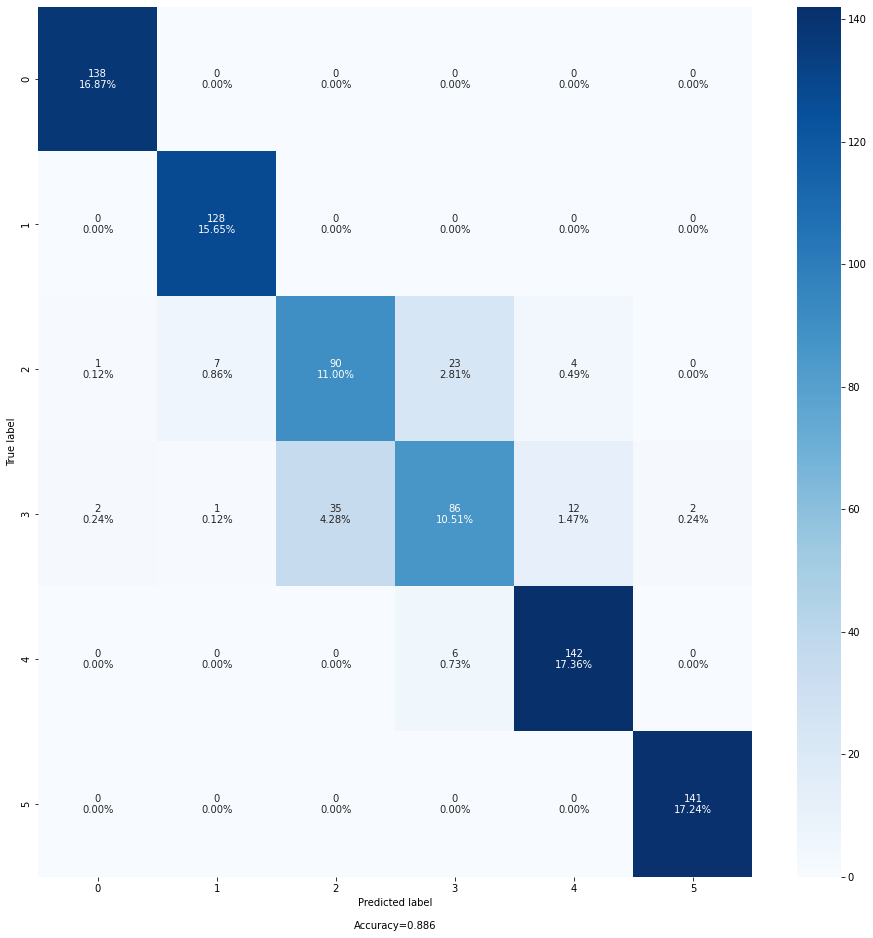

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, clear_output, HTML
from bokeh.models.mappers import LinearColorMapper


def plot_confusion_for_one_step(trial, step, title, ax=None, normalize=False):
    predictions = trial.tensor("predictions").value(step).round()
    labels = trial.tensor("labels").value(step).round()
    cm = confusion_matrix(
        labels,
        predictions,
    )
    num_classes = len(np.unique(labels))
    fig_height = num_classes+10
    make_confusion_matrix(cm, figsize=(fig_height,fig_height))


obj_names_for_error_plots = ["binary:logistic", "multi:softmax"]


if 'labels' in tensor_names and 'predictions' in tensor_names:
    if objective_metric in obj_names_for_error_plots:
        step = trial.steps()[-1]
        plot_confusion_for_one_step(trial, step=step, title="Confusion Matrix")
else:
    error_message = "\n\
    Labels and Predictions are missing in the debugger data output.\n\
    Please check if labels and predictions are included in your Debugger Hook Config.\n\
    "
    display(Markdown(error_message))


In [16]:
from IPython.display import display, Markdown

s='## Evaluation of the Confusion Matrix<a name="section4-1"></a>\n\
The following statistics summary of the confusion matrix is provided using \n\
the [Scikit-learn Metrics and Scoring APIs](https://scikit-learn.org/stable/modules/model_evaluation.html).\n\
You can use the following score metrics to evaluate the performance of your model: \n\
accuracy, precision, recall, and F1-score.\n\
\n\
For more information, see the following Scikit-learn documentation:\n\
- [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)\n\
- [Precision Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)\n\
- [Recall Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)\n\
- [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)\n\
'

if objective_metric in ["binary:logistic", "multi:softmax"]:
    display(Markdown(s))

## Evaluation of the Confusion Matrix<a name="section4-1"></a>
The following statistics summary of the confusion matrix is provided using 
the [Scikit-learn Metrics and Scoring APIs](https://scikit-learn.org/stable/modules/model_evaluation.html).
You can use the following score metrics to evaluate the performance of your model: 
accuracy, precision, recall, and F1-score.

For more information, see the following Scikit-learn documentation:
- [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Precision Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- [Recall Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
- [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)


In [17]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

obj_names_for_error_plots = ["binary:logistic", "multi:softmax"]

if objective_metric in obj_names_for_error_plots:

    y_test=trial.tensor("labels").value(plot_step).round()
    y_pred=trial.tensor("predictions").value(plot_step).round()
    display(Markdown(
        '**Overall Accuracy**\n\
        \n\
        Overall Accuracy: '
        +str(round(accuracy_score(y_test, y_pred),3))
    ))
    
    display(Markdown(
        '**Micro Performance Metrics**\n\
        \n\
        Performance metrics calculated globally by counting the total true positives, false negatives, and false positives.\n\
        \n\
        Micro Precision: '+str(round(precision_score(y_test, y_pred, average='micro'),3))+'\n\
        Micro Recall: '+str(round(recall_score(y_test, y_pred, average='micro'),3))+'\n\
        Micro F1-score: '+str(round(f1_score(y_test, y_pred, average='micro'),3))+'\n\
        '
    ))
    
    display(Markdown(
        '**Macro Performance Metrics**\n\
        \n\
        Performance metrics calculated for each label, and find their unweighted mean. \n\
        This does not take the class imbalance problem into account.\n\
        \n\
        Macro Precision: '+str(round(precision_score(y_test, y_pred, average='macro'),3))+'\n\
        Macro Recall: '+str(round(recall_score(y_test, y_pred, average='macro'),3))+'\n\
        Macro F1-score: '+str(round(f1_score(y_test, y_pred, average='macro'),3))+'\n\
        '
    ))
    
    display(Markdown(
        '**Weighted Performance Metrics**\n\
        \n\
        Performance metrics calculated for each label and their average weighted by support \n\
        (the number of true instances for each label). \n\
        This extends the macro option to take the class imbalance into account. \n\
        It might result in an F-score that is not between precision and recall. \n\
        \n\
        Weighted Precision: '+str(round(precision_score(y_test, y_pred, average='weighted'),3))+'\n\
        Weighted Recall: '+str(round(recall_score(y_test, y_pred, average='weighted'),3))+'\n\
        Weighted F1-score: '+str(round(f1_score(y_test, y_pred, average='weighted'),3))+'\n\
        '
    ))
    
    
    from sklearn.metrics import classification_report
    if 'labels' in tensor_names and 'predictions' in tensor_names:
        display(Markdown(
            '**Classification Report**\n\
            \n\
            The summary of the precision, recall, and F1-score for each class.'
        ))
        print(classification_report(y_test, y_pred))
    else:
        error_message = "\n\
        Labels and Predictions are missing in the debugger data output.\n\
        Please check if labels and predictions are included in your Debugger Hook Config.\n\
        "
        display(Markdown(error_message))

**Overall Accuracy**
        
        Overall Accuracy: 0.886

**Micro Performance Metrics**
        
        Performance metrics calculated globally by counting the total true positives, false negatives, and false positives.
        
        Micro Precision: 0.886
        Micro Recall: 0.886
        Micro F1-score: 0.886
        

**Macro Performance Metrics**
        
        Performance metrics calculated for each label, and find their unweighted mean. 
        This does not take the class imbalance problem into account.
        
        Macro Precision: 0.879
        Macro Recall: 0.884
        Macro F1-score: 0.88
        

**Weighted Performance Metrics**
        
        Performance metrics calculated for each label and their average weighted by support 
        (the number of true instances for each label). 
        This extends the macro option to take the class imbalance into account. 
        It might result in an F-score that is not between precision and recall. 
        
        Weighted Precision: 0.881
        Weighted Recall: 0.886
        Weighted F1-score: 0.882
        

**Classification Report**
            
            The summary of the precision, recall, and F1-score for each class.

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       138
         1.0       0.94      1.00      0.97       128
         2.0       0.72      0.72      0.72       125
         3.0       0.75      0.62      0.68       138
         4.0       0.90      0.96      0.93       148
         5.0       0.99      1.00      0.99       141

    accuracy                           0.89       818
   macro avg       0.88      0.88      0.88       818
weighted avg       0.88      0.89      0.88       818



In [18]:
from IPython.display import display, Markdown

s='## Accuracy Rate of Each Diagonal Element over Iteration <a name="section4-2"></a>\n\
\
The following graph shows the progression in accuracy rate of each class over iterations.\n\
\
- Each line is calculated by dividing the count of each diagonal element over the total population at validation steps captured by Debugger.\n\
- This plot provides visibility into the progression in the class-level accuracy, and you can evaluate which class is not well classified.\n\
If a certain class is under-performing, this might be, for example, due to the imbalanced class problem.\n\
It is recommended to see the first section, [The Distribution of True Labels of the Dataset](#section1),\n\
for more information about your data and suggested actions.\n\
'

if objective_metric in ["binary:logistic", "multi:softmax"]:
    display(Markdown(s))

## Accuracy Rate of Each Diagonal Element over Iteration <a name="section4-2"></a>
The following graph shows the progression in accuracy rate of each class over iterations.
- Each line is calculated by dividing the count of each diagonal element over the total population at validation steps captured by Debugger.
- This plot provides visibility into the progression in the class-level accuracy, and you can evaluate which class is not well classified.
If a certain class is under-performing, this might be, for example, due to the imbalanced class problem.
It is recommended to see the first section, [The Distribution of True Labels of the Dataset](#section1),
for more information about your data and suggested actions.


In [19]:
from collections import defaultdict
from scipy import stats
from bokeh.models.tickers import SingleIntervalTicker
import random
import numpy as np
from sklearn.metrics import confusion_matrix


def color_gen():
    co=(round(random.random()*250),round(random.random()*250),round(random.random()*250))
    return co
def plot_accuracy_rate():
    class_to_accuracy_map = defaultdict(list)
    label_steps = trial.tensor('labels').steps()
    pred_steps = trial.tensor('predictions').steps()
    validation_steps = sorted(list(set(label_steps).intersection(set(pred_steps))))
    for step in validation_steps:
        predictions = trial.tensor("predictions").value(step).round()
        labels = trial.tensor("labels").value(step).round()
        cm = confusion_matrix(
            labels,
            predictions
        )
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for class_ in range(len(cm)):
            class_to_accuracy_map[class_].append(cm[class_][class_])

    TOOLS="pan,wheel_zoom,reset,poly_select,box_select,box_zoom"
    TOOLTIPS = [
        ("step", "@steps"),
        ("accuracy", "@stat"),
    ] 
    bin_names = []
    data_list = []
    p = figure( 
        title=f"Accuracy Rate of Each Diagonal Element over Iteration",
        toolbar_location="left", 
        tools=TOOLS,
        tooltips=TOOLTIPS,
        plot_height=500,
        plot_width=1000
    )
    p.circle(0, 0, size=0.00000001, color= "#ffffff", legend_label="Class Names")
    for class_ in class_to_accuracy_map:
        source = ColumnDataSource(
            data=dict(
                steps=validation_steps, 
                stat=class_to_accuracy_map[class_]
            )
        )
        p.line(
            'steps', 
            'stat', 
            name=str(class_), 
            color=color_gen(), 
            line_width=4,
            source=source, 
            legend_label=str(class_)
        )
    p.legend.location = "center_right"
    p.legend.click_policy="hide"
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = 'Iteration'
    p.yaxis.axis_label = 'Accuracy'
    p.y_range.start = 0

    show(p)

avail_steps = trial.steps()
obj_names_for_error_plots = ["binary:logistic", "multi:softmax"]
if objective_metric in obj_names_for_error_plots:
    if 'labels' in tensor_names and 'predictions' in tensor_names:
        plot_accuracy_rate()
    else:
        error_message = "\n\
        Labels and Predictions are missing in the debugger data output.\n\
        Please check if labels and predictions are included in your Debugger Hook Config.\n\
        "
        display(Markdown(error_message))

In [20]:
from IPython.display import display, Markdown

s='## Receiver Operating Characteristic Curve <a name="section5"></a>\n\
\n\
The *Receiver Operating Characteristic* curve shows the performance of binary classification.\n\
\n\
* It measures the ratio of TPR over FPR, and the **Area Under Curve** (AUC) approaches to 1 as the model performance improves. The lowest AUC value is 0.5 (the area under the line of no-discrimination). \n\
* If the AUC value is less than 0.6, it means that your model significantly under-performs. Consider improving your data, tuning the model parameters, pruning the trees, or trying other classifiers.\n\
\n\
'

if objective_metric in ["binary:logistic"]:
    display(Markdown(s))


In [21]:
from sklearn.metrics import roc_curve, auc


# ROC Curve Will Only Be Plotted For Binary Classifiers

def plot_roc_curve():
    y_preds = trial.tensor('predictions').value(plot_step).round()
    labels = trial.tensor('labels').value(plot_step).round()
    fpr, tpr, thresholds = roc_curve(labels, y_preds)
    roc_auc = auc(fpr, tpr)
    # PLOT ROC curve
    source_ROC = ColumnDataSource(
        data=dict(x_fpr=fpr, 
                  y_tpr=tpr,
                  thresh=thresholds,
                 )
    )
    auc_legend = f'Area Under Curve:\n {(round(roc_auc, 5))}'
    TOOLTIPS=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Thresh", "@thresh")]
    TOOLS="pan,wheel_zoom,reset,poly_select,box_zoom"
    p = figure(title=f'ROC curve', tools=TOOLS, tooltips=TOOLTIPS)
    p.line('x_fpr', 'y_tpr', line_width=1, color="blue", source=source_ROC)
    p.circle('x_fpr', 'y_tpr', size=5, color="orange", legend_label=auc_legend, source=source_ROC, name='ROC')
    p.xaxis.axis_label = 'False Positive Rate'
    p.yaxis.axis_label = 'True Positive Rate'
    p.legend.location = 'bottom_right'
    show(p)
    
if objective_metric in ["binary:logistic"]:
    if 'labels' in tensor_names and 'predictions' in tensor_names:
        plot_roc_curve()
    else:
        error_message = "\n\
        Labels and Predictions are missing in the debugger data output.\n\
        Please check if labels and predictions are included in your Debugger Hook Config.\n\
        "
        display(Markdown(error_message))

In [22]:
from IPython.display import display, Markdown

s = '## Distribution of Residuals at the Last Saved Step <a name="section6"></a>\n\
\n\
The following histogram shows the distribution of residuals captured at the last step by Debugger.\n\
\n\
The residual is calculated as **predicted minus true** in this visualization. \n\
\n\
\n\
- For **regression**, the distribution should show a normal distribution centered at zero if the model is well trained.\n\
- For **classification**, the distribution shows how the number of correct prediction counts (at the zero residual bin) dominates over the number of wrong prediction counts.\n\
\n\
\n\
'

if objective_metric in SUPPORTED_OBJECTIVES:
    display(Markdown(s))


## Distribution of Residuals at the Last Saved Step <a name="section6"></a>

The following histogram shows the distribution of residuals captured at the last step by Debugger.

The residual is calculated as **predicted minus true** in this visualization. 


- For **regression**, the distribution should show a normal distribution centered at zero if the model is well trained.
- For **classification**, the distribution shows how the number of correct prediction counts (at the zero residual bin) dominates over the number of wrong prediction counts.




In [23]:
import numpy as np
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show


def make_plot(title, hist, edges, x):
    TOOLS="pan,xwheel_zoom,reset,box_select,box_zoom"    
    TOOLTIPS = [
        ("error", "$x"),
        ("count", "$y"),
    ]
    p = figure(
        title=title,  
        tools=TOOLS,
        toolbar_location="left",
        tooltips=TOOLTIPS
    )
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    p.y_range.start = 0
    p.xaxis.axis_label = 'Error'
    p.yaxis.axis_label = 'Error Count'
    p.grid.grid_line_color="white"
    return p

# Normal Distribution
from scipy.stats import norm
if 'labels' in tensor_names \
    and 'predictions' in tensor_names \
        and objective_metric in SUPPORTED_OBJECTIVES:
    pred = trial.tensor('predictions').value(plot_step)
    target = trial.tensor('labels').value(plot_step)
    if objective_metric in ["binary:logistic", "multi:softmax"]:
        pred = pred.round()
        target = target.round()
    error = pred-target
    hist, edges = np.histogram(error, density=False,bins="auto")
    mu, sigma = norm.fit(error)
    text_mu = round(mu,5)
    text_sigma = round(sigma,5)
    x = np.linspace(min(error), max(error))
    p1 = make_plot(f"Error Distribution at step:{plot_step}", hist, edges, x)
    show(gridplot([p1], ncols=2, plot_width=500, plot_height=500, toolbar_location="left"))

In [24]:
from IPython.display import display, Markdown

s = '## Absolute Validation Error per Label Bin over Iteration <a name="section7"></a>\n\
The following graph shows the progression of error (or residual) over iterations.\n\
- The absolute validation error of each bin should reduce over time.\n\
- Use this graph to identify poorly performing bins.\n\
- Interact with the graph by toggling different classes by clicking on the legend.\n\
'
if objective_metric in ["reg:squarederror"]:
    display(Markdown(s))


In [25]:
from scipy import stats
from bokeh.models.tickers import SingleIntervalTicker
import random

def color_gen():
    co=(round(random.random()*250),round(random.random()*250),round(random.random()*250))
    return co
def plot_abs_validation_error_per_label_bin_over_iteration():
    label_steps = trial.tensor('labels').steps()
    pred_steps = trial.tensor('predictions').steps()
    validation_steps = sorted(list(set(label_steps).intersection(set(pred_steps))))
    step_abs_error = []
    for step in validation_steps:
        label = trial.tensor('labels').value(step)
        pred = trial.tensor('predictions').value(step)
        abs_err = np.absolute(pred-label)
        step_abs_error.append(abs_err)
    labels = trial.tensor('labels').value(plot_step)
    statistics, bin_edge, bin_num = stats.binned_statistic(labels, step_abs_error, 'mean', bins=10)
    TOOLS="pan,wheel_zoom,reset,box_select,box_zoom"
    TOOLTIPS = [
        ("step", "@steps"),
        ("bin", "$name"),
    ] 
    bin_names = []
    data_list = []
    p = figure( 
        title=f"Absolute Validation Error Per Label Bin Over Iteration",
        toolbar_location="left", 
        tools=TOOLS,
        tooltips=TOOLTIPS,
        plot_height=500,
        plot_width=1000
    )
    for i in range(len(bin_edge)-1):
        stat = statistics[:,i]
        source = ColumnDataSource(
            data=dict(
                steps=validation_steps, 
                stat=stat
            )
        )
        bin_name = str(round(bin_edge[i], 5))+"-"+str(round(bin_edge[i+1], 5))
        p.line('steps', 'stat', name=bin_name, color=color_gen(), line_width=4, source=source, legend_label=bin_name)
    p.legend.location = "center_right"
    p.legend.click_policy="hide"
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label = 'Iteration'
    p.yaxis.axis_label = 'Error'
    p.y_range.start = 0

    show(p)

avail_steps = trial.steps()
obj_names_for_error_plots = ["reg:squarederror"]
if 'labels' in tensor_names and 'predictions' in tensor_names and objective_metric in obj_names_for_error_plots:
    plot_abs_validation_error_per_label_bin_over_iteration()
    

In [26]:
del trial